# interpretation of cell abundance matrix (c2l output)

In [ ]:
import scanpy as sc
import squidpy as sq
import pandas as pd

In [ ]:
!ls

In [ ]:
adata_st= sc.read_h5ad('decon_adata_st.h5ad')

## Discrete tissue regions

In [ ]:
# def BasicScanpyPreprocessing(adata, n_top_genes=2000, n_neighbors=10, n_pcs=40, random_state=20, resolution=None):
#     sc.pp.normalize_total(adata, target_sum=1e4) 
#     sc.pp.log1p(adata)
#     sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor='seurat')
#     #sc.pp.scale(adata, max_value=10) 
#     sc.tl.pca(adata, svd_solver='arpack')
#     sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=random_state)
#     sc.tl.umap(adata, random_state=random_state)
# #     sc.tl.tsne(adata, random_state=random_state)
#     sc.tl.leiden(adata, random_state=random_state, resolution= resolution)
#     return adata
# BasicScanpyPreprocessing(adata_st)

In [ ]:
adata_st

In [ ]:
sc.pp.neighbors(adata_st, use_rep="q05_cell_abundance_w_sf")
sc.tl.leiden(adata_st, resolution=0.5)

In [ ]:
adata_st.obs["region_cluster"] = adata_st.obs["leiden"].astype("category")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


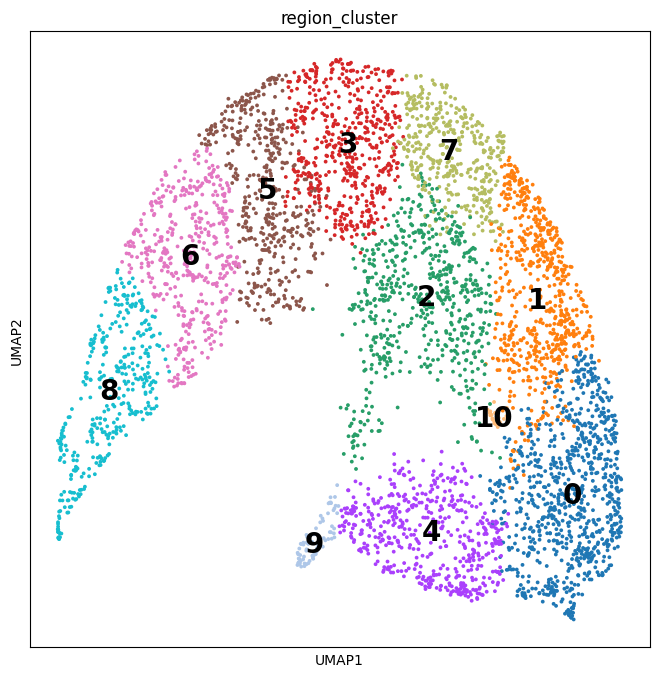

In [39]:
import matplotlib 
sc.tl.umap(adata_st, min_dist=0.3, spread=1)

with matplotlib.rc_context({"axes.facecolor": "white", "figure.figsize": [8, 8]}):
    sc.pl.umap(
        adata_st,
        color=["region_cluster"],
        size=30,
        color_map="RdPu",
        ncols=2,
        legend_loc="on data",
        legend_fontsize=20,
    )

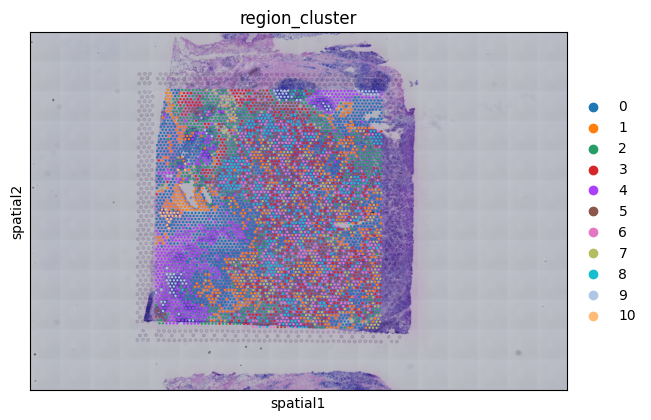

In [40]:
sq.pl.spatial_scatter(adata_st, color="region_cluster", library_key="patient_region_id")

### It’s also important here to perform QC: check that the total cell count per spot (sum of all types) correlates with histological density (e.g. H&E cellularity)
### also here, its a good way to compare cluster of each tissue to identify immune rich, cancer rich and TME across different section of the same cancer type

In [ ]:
# Access estimated cell abundance matrix
cell_abundance = adata_st.obsm['q05_cell_abundance_w_sf']

# Add region cluster info to the matrix
cell_abundance['region_cluster'] = adata_st.obs['region_cluster'].values

# Compute average cell-type abundance per cluster
region_profiles = cell_abundance.groupby('region_cluster').mean()

Text(0.5, 1.0, 'Average Cell Type Composition per Spatial Region Cluster')

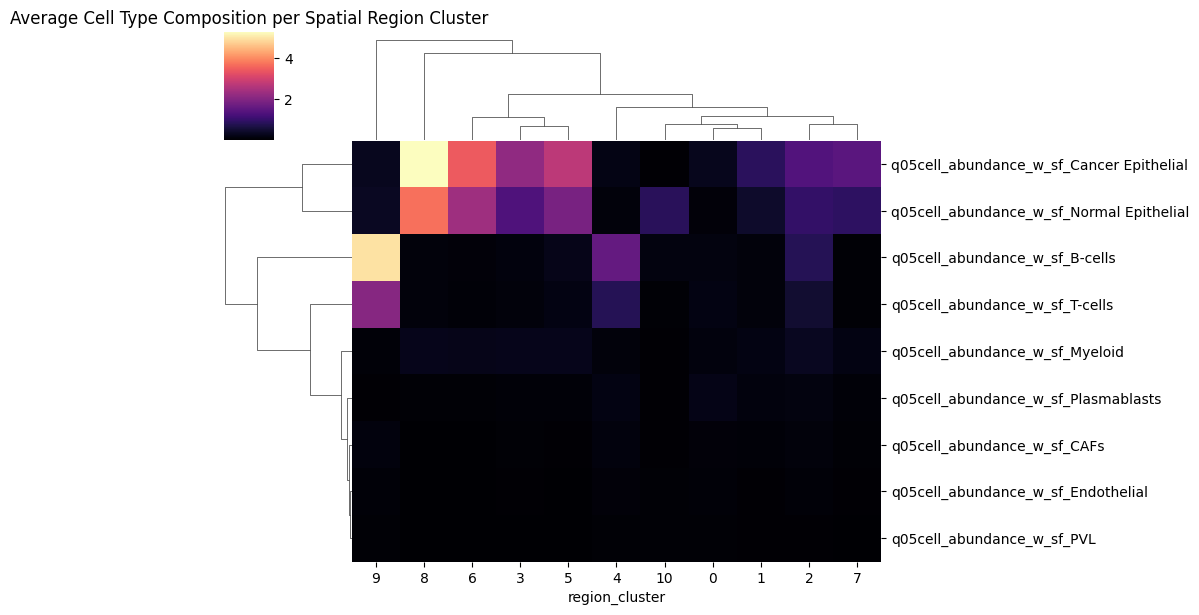

In [41]:
sns.clustermap(region_profiles.T, cmap='magma', figsize=(10, 6))
plt.title("Average Cell Type Composition per Spatial Region Cluster")

Text(0.5, 1.0, 'Cell-type composition in cluster 3')

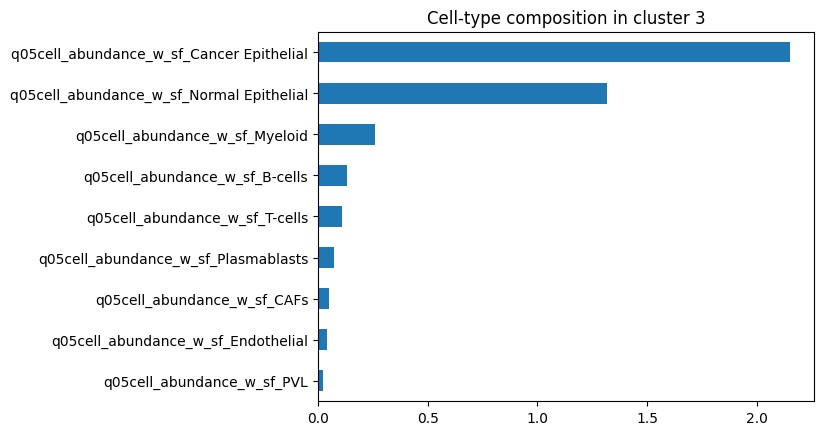

In [42]:
region_profiles.loc["3"].sort_values().plot(kind='barh')
plt.title("Cell-type composition in cluster 3")

### we can here look at each cluster individually 

/tmp/ipykernel_31/2450237256.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(adata_st, color="region_cluster_label", cmap="Set3", title="Annotated Tissue Regions")


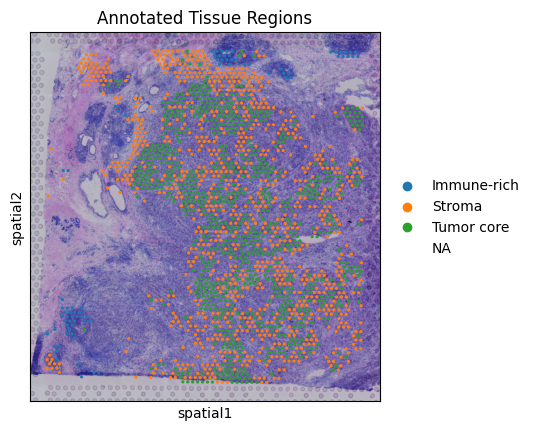

In [43]:
adata_st.obs["region_cluster_label"] = adata_st.obs["region_cluster"].map({
    "9": "Immune-rich",
    "8": "Tumor core",
    "6": "Tumor core",
    "3": "Stroma",
    "5": "Stroma"
})

sc.pl.spatial(adata_st, color="region_cluster_label", cmap="Set3", title="Annotated Tissue Regions")

### *this image for example only, no real biology or interpretation can be concluded here*

In [ ]:
adata_st.write('DiscreteRegion_adata_st.h5ad')

### using the previous same concept we can use non-negative matrix factorization (NMF) of the abundance matrix can uncover co-localized cell communities Each NMF factor represents a weighted combination of cell types that tend to appear together
### For instance, one factor might load on B cells, T follicular helper cells and dendritic cells, corresponding to a lymphoid niche. In fact, Kleshchevnikov et al. showed that NMF of cell2location results “capture co-localised cell types” and naturally allow multiple microenvironments to coexist in a spot
https://doi.org/10.1038/s41587-021-01139-4

further investigate the following 
- Tertiary lymphoid structures (TLS). TLS are lymph node–like immune foci in tumors, reported in breast cancer In spatial data, TLS appear as small patches of high B-cell (follicular helper) and dendritic cell signals If H&E or immunostains show lymphoid aggregates
- Bassiouni (we will use this data ) annotated a dense lymphoid infiltrate in a TNBC sample and showed that spots there had high immune signature scores (ssGSEA) and low tumor purity and verify that stromal clusters from cell2location align with annotated fibrotic regions. as seen In Bassiouni data a fibrotic region had low tumor purity and was enriched for stromal signatures
- Markers of hypoxia, necrosis or vasculature (angiogeneiesis)